In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/archive_2.zip' -d '/content/data'

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/train/sad/Training_65242339.jpg  
  inflating: /content/data/train/sad/Training_65267116.jpg  
  inflating: /content/data/train/sad/Training_65275626.jpg  
  inflating: /content/data/train/sad/Training_6529266.jpg  
  inflating: /content/data/train/sad/Training_65329617.jpg  
  inflating: /content/data/train/sad/Training_65338712.jpg  
  inflating: /content/data/train/sad/Training_65338797.jpg  
  inflating: /content/data/train/sad/Training_65387162.jpg  
  inflating: /content/data/train/sad/Training_65404494.jpg  
  inflating: /content/data/train/sad/Training_65426218.jpg  
  inflating: /content/data/train/sad/Training_65430136.jpg  
  inflating: /content/data/train/sad/Training_65437377.jpg  
  inflating: /content/data/train/sad/Training_6545735.jpg  
  inflating: /content/data/train/sad/Training_65463385.jpg  
  inflating: /content/data/train/sad/Training_65473985.jpg  
  inflating: /content/data/train/sad

In [3]:
# import required packages
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import pandas as pd
import seaborn as sns
from tensorflow.keras.applications import MobileNet
from keras import layers

In [13]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(rescale=1./255,rotation_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,)
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        '/content/data/train',
        target_size=(48, 48),
        batch_size=64,
        class_mode='categorical')

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        '/content/data/test',
        target_size=(48, 48),
        batch_size=64,
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [14]:
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

In [15]:
base_model = MobileNet(input_shape = (48, 48, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False


# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(7, activation='softmax')(x)

model1 = tf.keras.models.Model(base_model.input, x)

model1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [16]:
vgg_model = model1.fit(train_generator, validation_data = validation_generator, epochs = 10)

Epoch 1/10
449/449 [==============================] - 45s 98ms/step - loss: 1.7875 - accuracy: 0.2615 - val_loss: 1.7525 - val_accuracy: 0.2721
Epoch 2/10
449/449 [==============================] - 52s 116ms/step - loss: 1.7702 - accuracy: 0.2713 - val_loss: 1.7467 - val_accuracy: 0.2802
Epoch 3/10
449/449 [==============================] - 39s 87ms/step - loss: 1.7636 - accuracy: 0.2725 - val_loss: 1.7365 - val_accuracy: 0.2867
Epoch 4/10
449/449 [==============================] - 39s 88ms/step - loss: 1.7629 - accuracy: 0.2762 - val_loss: 1.7325 - val_accuracy: 0.2875
Epoch 5/10
449/449 [==============================] - 40s 88ms/step - loss: 1.7603 - accuracy: 0.2758 - val_loss: 1.7387 - val_accuracy: 0.2790
Epoch 6/10
449/449 [==============================] - 39s 86ms/step - loss: 1.7637 - accuracy: 0.2749 - val_loss: 1.7400 - val_accuracy: 0.2806
Epoch 7/10
449/449 [==============================] - 40s 89ms/step - loss: 1.7596 - accuracy: 0.2777 - val_loss: 1.7358 - val_accuracy

In [17]:
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    plt.style.use('dark_background')
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('plot.png')
    plt.show()

<ipython-input-17-37e2b4767761>:13: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
<ipython-input-17-37e2b4767761>:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)


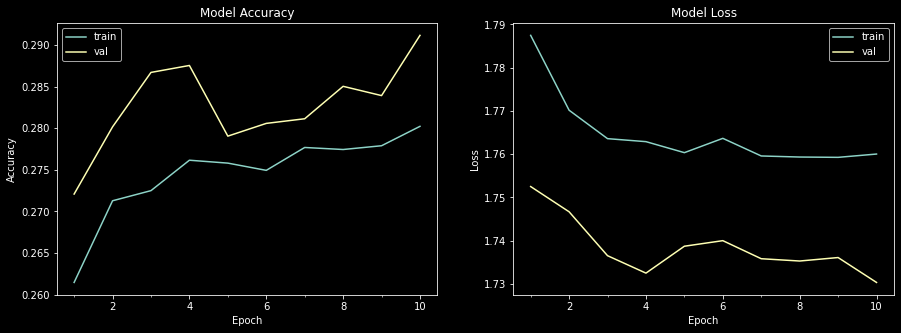

In [18]:
plot_model_history(vgg_model)

In [19]:
tr_predictions = model1.predict(train_generator)

449/449 [==============================] - 35s 77ms/step


-----------------------------------------------------------------
[[  28    0   38 2452  454  695  328]
 [   6    0    3  274   44   74   35]
 [  41    0   42 2549  444  683  338]
 [  80    0   78 4501  815 1153  588]
 [  43    0   41 3147  530  804  400]
 [  42    0   54 3048  529  790  367]
 [  32    0   32 1985  331  520  271]]


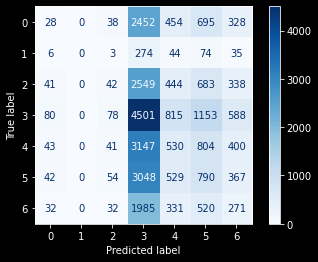

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.10      0.01      0.01      3995
           1       0.00      0.00      0.00       436
           2       0.15      0.01      0.02      4097
           3       0.25      0.62      0.36      7215
           4       0.17      0.11      0.13      4965
           5       0.17      0.16      0.17      4830
           6       0.12      0.09      0.10      3171

    accuracy                           0.21     28709
   macro avg       0.14      0.14      0.11     28709
weighted avg       0.17      0.21      0.16     28709



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

In [20]:
print("-----------------------------------------------------------------")
# confusion matrix
c_matrix = confusion_matrix(train_generator.classes, tr_predictions.argmax(axis=1))
print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=emotion_dict)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print("-----------------------------------------------------------------")
print(classification_report(train_generator.classes, tr_predictions.argmax(axis=1)))
clf_report = classification_report(train_generator.classes, tr_predictions.argmax(axis=1),output_dict=True)

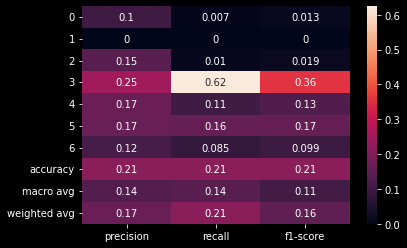

In [21]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

In [23]:
# do prediction on test data
predictions = model1.predict(validation_generator)

113/113 [==============================] - 3s 26ms/step


-----------------------------------------------------------------
[[   8    0    6  699   82   99   64]
 [   1    0    3   79   13    7    8]
 [  10    0   14  729   86  112   73]
 [  13    0   24 1307  145  173  112]
 [   8    0   12  881  104  139   89]
 [   6    0   16  897  100  129   99]
 [   4    0    6  591   63   99   68]]


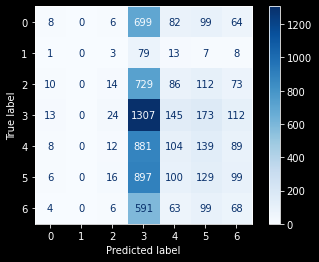

-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.16      0.01      0.02       958
           1       0.00      0.00      0.00       111
           2       0.17      0.01      0.03      1024
           3       0.25      0.74      0.38      1774
           4       0.18      0.08      0.11      1233
           5       0.17      0.10      0.13      1247
           6       0.13      0.08      0.10       831

    accuracy                           0.23      7178
   macro avg       0.15      0.15      0.11      7178
weighted avg       0.18      0.23      0.15      7178



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

In [25]:
print("-----------------------------------------------------------------")
# confusion matrix
c_matrix = confusion_matrix(validation_generator.classes, predictions.argmax(axis=1))
print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=emotion_dict)
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print("-----------------------------------------------------------------")
print(classification_report(validation_generator.classes, predictions.argmax(axis=1)))
clf_report1 = classification_report(validation_generator.classes, predictions.argmax(axis=1),output_dict=True)

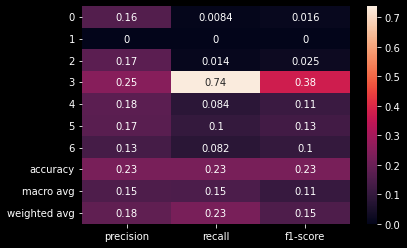

In [26]:
sns.heatmap(pd.DataFrame(clf_report1).iloc[:-1, :].T, annot=True)

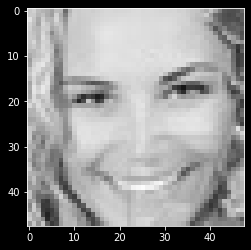

In [27]:
img = load_img("/content/data/test/happy/PrivateTest_10077120.jpg",target_size = (48,48))
img = np.array(img)
plt.imshow(img)

In [29]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,3)
result = model1.predict(img)
result = list(result[0])
print(result)
img_index = result.index(max(result))
print(emotion_dict[img_index])

1/1 [==============================] - 1s 582ms/step
[0.14557575, 0.012286078, 0.16180362, 0.22934578, 0.16864893, 0.15360908, 0.12873071]
Happy


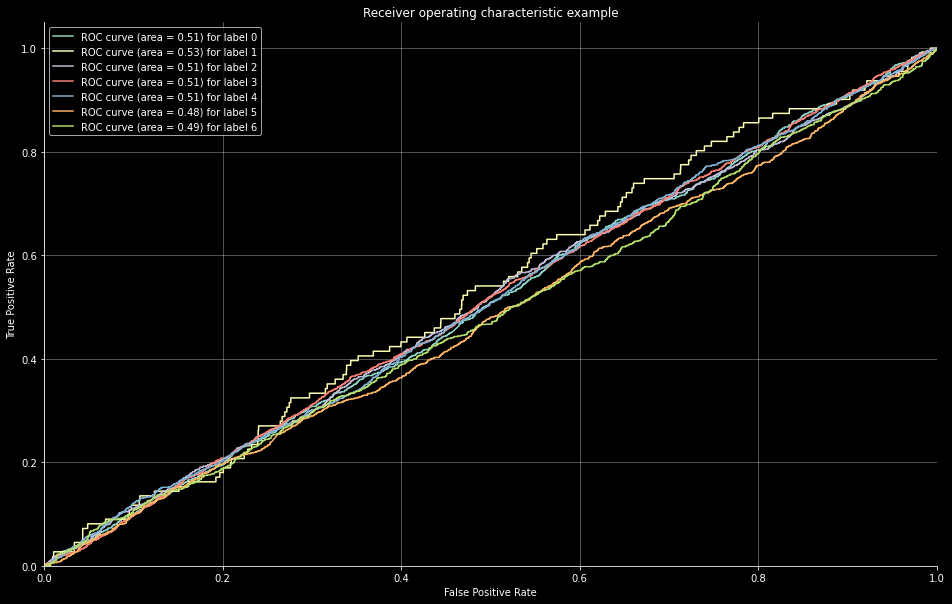

In [30]:
def plot_multiclass_roc( prediction, y_test, n_classes, figsize=(17, 6)):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], prediction[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(predictions, validation_generator.classes, n_classes=7, figsize=(16, 10))